In [1]:
import os
import numpy as np
import random
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
os.environ["TF_DETERMINISTIC_OPS"] = "1"

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Layer
from tensorflow.keras import backend as K

df = pd.read_csv('/content/city_day.csv')

print(f"NaN values in dataset before cleaning: {df.isna().sum().sum()}")

df = df.dropna()
print(f"NaN values after cleaning: {df.isna().sum().sum()}")
print(f"Shape after cleaning: {df.shape}")

features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
X = df[features].values
y = df['AQI'].values

X = np.nan_to_num(X)
y = np.nan_to_num(y)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_cl = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_cl = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

NaN values in dataset before cleaning: 88488
NaN values after cleaning: 0
Shape after cleaning: (6236, 16)


In [3]:
# ------------------------------
# ATTENTION LAYER
# ------------------------------
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(1,),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        score = K.tanh(K.dot(inputs, self.W) + self.b)
        score = K.squeeze(score, axis=-1)
        weights = K.softmax(score)
        weights = K.expand_dims(weights, axis=-1)
        context = inputs * weights
        return K.sum(context, axis=1)

In [4]:
inp = Input(shape=(1, X_train.shape[1]))

x = Conv1D(filters=64, kernel_size=1, activation='relu')(inp)
x = MaxPooling1D(pool_size=1)(x)

x = Attention()(x)

x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(1)(x)

cnn_att_model = Model(inputs=inp, outputs=out)

cnn_att_model.compile(optimizer='adam', loss='mse')

history = cnn_att_model.fit(
    X_train_cl, y_train, epochs=50, batch_size=32,
    validation_split=0.1, shuffle=False, verbose=1
)

train_pred = cnn_att_model.predict(X_train_cl)
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print("CNN + Attention Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, train_pred_inv))
print("R²  :", r2_score(y_train_actual, train_pred_inv))

test_pred = cnn_att_model.predict(X_test_cl)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

cnn_att_rmse = sqrt(mean_squared_error(y_test_actual, test_pred_inv))
cnn_att_mae = mean_absolute_error(y_test_actual, test_pred_inv)
cnn_att_r2 = r2_score(y_test_actual, test_pred_inv)

print("\nCNN + Attention Test Evaluation:")
print("RMSE:", cnn_att_rmse)
print("MAE :", cnn_att_mae)
print("R²  :", cnn_att_r2)

sample_input = pd.DataFrame([[26, 50, 1, 19, 18, 23, 1, 3, 42, 2, 6, 1]],
                            columns=features)

sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1, 1, sample_scaled.shape[1])

pred = cnn_att_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)
aqi = pred[0][0]

print("\nCNN + Attention Prediction:", aqi)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0148 - val_loss: 0.0016
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:
# ---------------- LSTM + ATTENTION MODEL ---------------- #
att_model = Sequential()
att_model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
att_model.add(Attention())
att_model.add(Dropout(0.3))
att_model.add(Dense(50, activation='relu'))
att_model.add(Dense(1))

att_model.compile(optimizer='adam', loss='mse')

att_history = att_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# ---------------- TRAIN EVALUATION ---------------- #
train_pred = att_model.predict(X_train_cl)
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print("\nLSTM + Attention Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, train_pred_inv))
print("R²  :", r2_score(y_train_actual, train_pred_inv))

# ---------------- TEST EVALUATION ---------------- #
test_pred = att_model.predict(X_test_cl)
test_pred = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

lstm_att_rmse = sqrt(mean_squared_error(y_test_actual, test_pred))
lstm_att_mae = mean_absolute_error(y_test_actual, test_pred)
lstm_att_r2 = r2_score(y_test_actual, test_pred)

print("\nLSTM + Attention Test Evaluation:")
print("RMSE:", lstm_att_rmse)
print("MAE :", lstm_att_mae)
print("R²  :", lstm_att_r2)

# ---------------- SAMPLE PREDICTION ---------------- #
sample_input = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)
sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1,1,sample_scaled.shape[1])

pred = att_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nPrediction AQI:", pred[0][0])
print("Quality:", get_aqi_quality(pred[0][0]))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0222 - val_loss: 0.0028
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [6]:
# --------------------------- BiLSTM + Attention MODEL ---------------------------
inputs = Input(shape=(1, X_train.shape[1]))
x = Bidirectional(LSTM(100, return_sequences=True))(inputs)
x = Attention()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

bilstm_att_model = Model(inputs, output)
bilstm_att_model.compile(optimizer='adam', loss='mse')

history = bilstm_att_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# ---------------------------
# TRAIN EVALUATION
# ---------------------------
train_pred = bilstm_att_model.predict(X_train_cl)
train_pred = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

train_rmse = sqrt(mean_squared_error(y_train_actual, train_pred))
train_mae = mean_absolute_error(y_train_actual, train_pred)
train_r2 = r2_score(y_train_actual, train_pred)

print("\nBiLSTM + Attention Training:")
print("RMSE:", train_rmse)
print("MAE :", train_mae)
print("R²  :", train_r2)

# ---------------------------
# TEST EVALUATION
# ---------------------------
test_pred = bilstm_att_model.predict(X_test_cl)
test_pred = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

bilstm_att_rmse = sqrt(mean_squared_error(y_test_actual, test_pred))
bilstm_att_mae = mean_absolute_error(y_test_actual, test_pred)
bilstm_att_r2 = r2_score(y_test_actual, test_pred)

print("\nBiLSTM + Attention Test Results:")
print("RMSE:", bilstm_att_rmse)
print("MAE :", bilstm_att_mae)
print("R²  :", bilstm_att_r2)

# ---------------------------
# SAMPLE PREDICTION
# ---------------------------
sample = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)
sample_scaled = scaler_X.transform(sample)
sample_reshaped = sample_scaled.reshape(1,1, sample_scaled.shape[1])

pred = bilstm_att_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)

aqi = pred[0][0]

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nBiLSTM + Attention Prediction:")
print("AQI:", aqi)
print("Quality:", get_aqi_quality(aqi))


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0173 - val_loss: 0.0019
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [7]:
# -----------------------
# CNN + LSTM + Attention Model
# -----------------------
inp = Input(shape=(1, X_train.shape[1]))

x = Conv1D(64, kernel_size=1, activation='relu')(inp)
x = MaxPooling1D(pool_size=1)(x)

x = LSTM(100, return_sequences=True)(x)

x = Attention()(x)

x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(1)(x)

cnn_lstm_att_model = Model(inputs=inp, outputs=out)

cnn_lstm_att_model.compile(optimizer='adam', loss='mse')

history = cnn_lstm_att_model.fit(
    X_train_cl, y_train, epochs=50, batch_size=32,
    validation_split=0.1, shuffle=False, verbose=1
)

train_pred = cnn_lstm_att_model.predict(X_train_cl)
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print("CNN + LSTM + Attention Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, train_pred_inv))
print("R²  :", r2_score(y_train_actual, train_pred_inv))

test_pred = cnn_lstm_att_model.predict(X_test_cl)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

cnn_lstm_att_rmse = sqrt(mean_squared_error(y_test_actual, test_pred_inv))
cnn_lstm_att_mae = mean_absolute_error(y_test_actual, test_pred_inv)
cnn_lstm_att_r2 = r2_score(y_test_actual, test_pred_inv)

print("\nCNN + LSTM + Attention Test Evaluation:")
print("RMSE:", cnn_lstm_att_rmse)
print("MAE :", cnn_lstm_att_mae)
print("R² :", cnn_lstm_att_r2)

sample_input = pd.DataFrame([[26, 50, 1, 19, 18, 23, 1, 3, 42, 2, 6, 1]],
                            columns=features)

sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1, 1, sample_scaled.shape[1])

pred = cnn_lstm_att_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)

print("\nCNN + LSTM + Attention Prediction:", pred[0][0])


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0135 - val_loss: 0.0018
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 9.6100e-04
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 9.7690e-04
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [8]:
# ------------------------------
# CNN + BiLSTM + Attention MODEL
# ------------------------------
input_layer = Input(shape=(1, X_train.shape[1]))

x = Conv1D(filters=64, kernel_size=1, activation='relu')(input_layer)
x = Bidirectional(LSTM(100, return_sequences=True))(x)

x = Attention()(x)

x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(1)(x)

cnn_bilstm_att_model = Model(inputs=input_layer, outputs=output)

cnn_bilstm_att_model.compile(optimizer='adam', loss='mse')

cnn_bilstm_att_history = cnn_bilstm_att_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)


# ------------------------------
# TRAINING EVALUATION
# ------------------------------
train_pred = cnn_bilstm_att_model.predict(X_train_cl)
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

train_rmse = sqrt(mean_squared_error(y_train_actual, train_pred_inv))
train_mae = mean_absolute_error(y_train_actual, train_pred_inv)
train_r2 = r2_score(y_train_actual, train_pred_inv)

print(" CNN + BiLSTM + Attention Training Evaluation:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE : {train_mae:.4f}")
print(f"R²  : {train_r2:.4f}")


# ------------------------------
# TEST EVALUATION
# ------------------------------
test_pred = cnn_bilstm_att_model.predict(X_test_cl)
test_pred_inv = scaler_y.inverse_transform(test_pred)

y_test_actual = scaler_y.inverse_transform(y_test)

cnn_bilstm_att_rmse = sqrt(mean_squared_error(y_test_actual, test_pred_inv))
cnn_bilstm_att_mae = mean_absolute_error(y_test_actual, test_pred_inv)
cnn_bilstm_att_r2 = r2_score(y_test_actual, test_pred_inv)

print("\nCNN + BiLSTM + ATTENTION Hybrid Model Results:")
print(f"RMSE: {cnn_bilstm_att_rmse}")
print(f"MAE: {cnn_bilstm_att_mae}")
print(f"R² Score: {cnn_bilstm_att_r2}")


# ------------------------------
# SAMPLE PREDICTION (Same)
# ------------------------------
sample_input = pd.DataFrame([[26, 50, 1, 19, 18, 23, 1, 3, 42, 2, 6, 1]],
                            columns=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene'])

sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1, 1, sample_scaled.shape[1])

pred = cnn_bilstm_att_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)

aqi_val = pred[0][0]

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nCNN + BiLSTM + Attention Prediction:")
print("AQI:", aqi_val)
print("Quality:", get_aqi_quality(aqi_val))


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0149 - val_loss: 0.0018
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - val_loss: 9.6577e-04
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


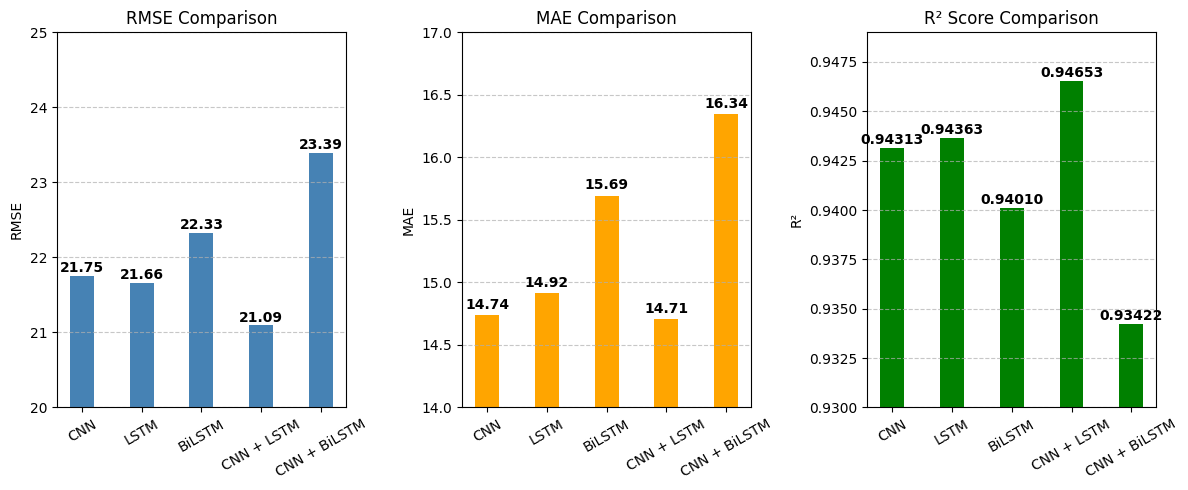

In [9]:
models = ['CNN', 'LSTM', 'BiLSTM', 'CNN + LSTM', 'CNN + BiLSTM']

rmse_values = [cnn_att_rmse, lstm_att_rmse, bilstm_att_rmse, cnn_lstm_att_rmse, cnn_bilstm_att_rmse]
mae_values = [cnn_att_mae, lstm_att_mae, bilstm_att_mae, cnn_lstm_att_mae, cnn_bilstm_att_mae]
r2_values  = [cnn_att_r2, lstm_att_r2, bilstm_att_r2, cnn_lstm_att_r2, cnn_bilstm_att_r2]

bar_width = 0.4
x = np.arange(len(models))

plt.figure(figsize=(12, 5))

# R² Score
plt.subplot(1, 3, 3)
plt.bar(x, r2_values, color=['green'], width=bar_width)
plt.xticks(x, models, rotation=30)
plt.title('R² Score Comparison')
plt.ylabel('R²')
plt.ylim(0.93, 0.949)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0002, f'{v:.5f}', ha='center', fontweight='bold')

# RMSE Comparison
plt.subplot(1, 3, 1)
plt.bar(x, rmse_values, color=['steelblue'], width=bar_width)
plt.xticks(x, models, rotation=30)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.ylim(20, 25)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')


# MAE Comparison
plt.subplot(1, 3, 2)
plt.bar(x, mae_values, color=['orange'], width=bar_width)
plt.xticks(x, models, rotation=30)
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.ylim(14, 17)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(mae_values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
